In [1]:
pwd = %pwd

import os, sys
sys.path.insert(0, os.path.join(pwd, "../"))

import warnings
warnings.simplefilter("ignore")

import srl

-------

# はじめに

ここでは本フレームワークでの自作環境を作成する方法を説明します。  
構成としては大きく以下です。  

+ 1.実装するクラスの説明
  + 1-1.OpenAI gymクラス
  + 1-2.Baseクラス
  + 1-3.一人プレイ（singleplay）
  + 1-4.ターン制二人プレイ(turnbase2player)
+ 2.Spaceクラスの説明
+ 3.登録
+ 4.実装例(singleplay)
+ 5.テスト
+ 6.Q学習による学習


# 1.実装クラス

自作環境を作成する方法は現在以下の二つがあります。

+ (OpenAI gym)[https://github.com/openai/gym]（以下gym）の環境を用意する
+ 本フレームワークで実装されている 'srl.base.env.EnvBase' を継承する

それぞれについて説明します。

## 1-1. gym の環境を利用

gym の環境を利用を利用する場合は別途 `pip install gym` が必要です。  
また、一部本フレームワークに特化した内容にはならない点があります。  
1-2で説明があるBaseクラスを見比べてもらえれば分かりますが、アルゴリズム向けに特化した情報が増えています。  

※gym側の更新等により不正確な情報になる可能性があります。より正確な情報は公式(<https://www.gymlibrary.dev/>)を見てください。


### gym.Env

gymの自作環境の作成方法ですが、gym.Envを継承して作成します。

In [2]:
from typing import Optional, Tuple
import gym
from gym import spaces
import numpy as np

class MyGymEnv(gym.Env):
    # 利用できるrender_modesを指定するようです
    metadata = {"render_modes": ["ansi", "rgb_array"], "render_fps": 4}
    
    def __init__(self, render_mode: Optional[str] = None):
        self.render_mode = render_mode
        """
        initで以下2つの変数を定義する必要あり
        spaces.Space型については省略します。
        
        self.action_space      : アクションが取りうる範囲を指定
        self.observation_space : 状態が取りうる範囲を指定
        """
        
        self.action_space: spaces.Space = spaces.Discrete(2)
        self.observation_space: spaces.Space = spaces.Box(-1, 1, shape=(1,))

    def reset(self, *, seed=None, options=None)-> Tuple[np.ndarray, dict]:
        super().reset(seed=seed)
        """ 1エピソードの最初に実行。（初期化処理を実装）
        return 初期状態, 情報
        """
        return np.array([0], dtype=np.float32), {}
    
    def step(self, action) -> Tuple[np.ndarray, float, bool, bool, dict]:
        """ actionを元に1step進める処理を実装
        return (
            1step後の状態,
            即時報酬,
            予定通り終了したらTrue(terminated),
            予想外で終了したらTrue(truncated),
            情報(任意),
        )
        """
        return np.array([0], dtype=np.float32), 0.0, True, False, {}

    def render(self):
        """
        描画処理を書きます。
        """
        pass


### 登録

環境クラスを作成したら登録します。  
登録時のid名は "名前-vX" という形式である必要があります。  

In [3]:
import gym.envs.registration

gym.envs.registration.register(
    id="MyGymEnv-v0",
    entry_point=__name__ + ":MyGymEnv",
    max_episode_steps=10,
)


以下のように呼び出せます。

In [4]:
import gym
env = gym.make("MyGymEnv-v0")

observation = env.reset()

for _ in range(10):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    env.render()

    if terminated or truncated:
        observation = env.reset()

env.close()


## 1-2.Baseクラス

本フレームワーク共通で使用する基底クラス(`srl.base.env.EnvBase`)の説明です。  
このクラスを直接継承して必要な関数を実装しても問題ありませんが、環境によっては特化した基底クラスがあるのでそちらを継承したほうが楽に作成できます。  


In [5]:
from typing import Optional, Tuple, List, Any

from srl.base.env import EnvBase
from srl.base.env.space import SpaceBase
from srl.base.define import EnvAction, EnvObservation, EnvObservationType, Info


class MyEnvBase(EnvBase):

    @property
    def action_space(self) -> SpaceBase:
        """ アクションの取りうる範囲を返します(SpaceBaseは後述) """
        raise NotImplementedError()

    @property
    def observation_space(self) -> SpaceBase:
        """ 状態の取りうる範囲を返します(SpaceBaseは後述) """
        raise NotImplementedError()

    @property
    def observation_type(self) -> EnvObservationType:
        """ 状態の種類を返します。
        EnvObservationType は列挙型で以下です。
        DISCRETE  : 離散
        CONTINUOUS: 連続
        GRAY_2ch  : グレー画像(2ch)
        GRAY_3ch  : グレー画像(3ch)
        COLOR     : カラー画像
        SHAPE2    : 2次元空間
        SHAPE3    : 3次元空間
        """
        raise NotImplementedError()

    @property
    def max_episode_steps(self) -> int:
        """ 1エピソードの最大ステップ数 """
        raise NotImplementedError()

    @property
    def player_num(self) -> int:
        """ プレイヤー人数 """
        raise NotImplementedError()

    def reset(self) -> Tuple[EnvObservation, int, Info]:
        """ 1エピソードの最初に実行。（初期化処理を実装）
        Returns: (
            init_state        : 初期状態
            next_player_index : 最初のプレイヤーの番号
            info              : 任意の情報
        )
        """
        raise NotImplementedError()

    def step(
        self,
        action: EnvAction,
        player_index: int,
    ) -> Tuple[EnvObservation, List[float], bool, int, Info]:
        """ actionとplayerを元に1step進める処理を実装

        Args:
            action (EnvAction): player_index の action
            player_index (int): stepで行動するプレイヤーのindex

        Returns: (
            next_state : 1step後の状態
            [
                player1 reward,
                player2 reward,
                ...
            ],
            done,
            next_player_index,
            info,
        )
        """
        raise NotImplementedError()

    # backup/restore で現環境を復元できるように実装
    def backup(self) -> Any:
        raise NotImplementedError()
    def restore(self, data: Any) -> None:
        raise NotImplementedError()

    # ------------------------------------
    # 以下は option です。（必須ではない）
    # ------------------------------------
    def close(self) -> None:
        """ 終了処理を実装 """
        pass
    
    # 描画関係
    def render_terminal(self, **kwargs) -> None:
        pass
    def render_rgb_array(self, **kwargs) -> Optional[np.ndarray]:
        return None

    def get_invalid_actions(self, player_index: int) -> list:
        """ 無効なアクションがある場合は配列で返す """
        return []

    def make_worker(self, name: str) -> Optional["srl.base.rl.base.WorkerBase"]:
        """ 環境に特化したAIを返す """
        return None

    def set_seed(self, seed: Optional[int] = None) -> None:
        """ 乱数seed """
        pass



## 1-3.一人プレイ用のクラス

一人プレイ用に特化した基底クラスの説明です。
（`srl.base.env.genre.singleplay.SinglePlayEnv`）


In [6]:
from typing import Optional, Tuple, Any

from srl.base.env.genre import SinglePlayEnv
from srl.base.env.space import SpaceBase
from srl.base.define import EnvObservationType, Info


class MySinglePlayEnv(SinglePlayEnv):

    @property
    def action_space(self) -> SpaceBase:
        """ アクションの取りうる範囲を返します(SpaceBaseは後述) """
        raise NotImplementedError()

    @property
    def observation_space(self) -> SpaceBase:
        """ 状態の取りうる範囲を返します(SpaceBaseは後述) """
        raise NotImplementedError()

    @property
    def observation_type(self) -> EnvObservationType:
        """ 状態の種類を返します。
        EnvObservationType は列挙型で以下です。
        DISCRETE  : 離散
        CONTINUOUS: 連続
        GRAY_2ch  : グレー画像(2ch)
        GRAY_3ch  : グレー画像(3ch)
        COLOR     : カラー画像
        SHAPE2    : 2次元空間
        SHAPE3    : 3次元空間
        """
        raise NotImplementedError()

    @property
    def max_episode_steps(self) -> int:
        """ 1エピソードの最大ステップ数 """
        raise NotImplementedError()

    def call_reset(self) -> Tuple[EnvObservation, Info]:
        """ 1エピソードの最初に実行。（初期化処理を実装）
        Returns: (
            EnvObservation (observation_spaceの型): 初期状態
            Info                                 : 任意の情報
        )
        """
        raise NotImplementedError()

    def call_step(self, action) -> Tuple[EnvObservation, float, bool, Info]:
        """ actionを元に1step進める処理を実装
        Returns: (
            next_state : 1step後の状態
            reward     : 即時報酬
            done       : 終了したかどうか
            info       : 任意の情報
        )
        """
        raise NotImplementedError()

    # backup/restore で現環境を復元できるように実装
    def backup(self) -> Any:
        raise NotImplementedError()
    def restore(self, data: Any) -> None:
        raise NotImplementedError()

    # ------------------------------------
    # 以下は option です。（必須ではない）
    # ------------------------------------
    def close(self) -> None:
        """ 終了処理を実装 """
        pass
    
    # 描画関係
    def render_terminal(self, **kwargs) -> None:
        pass
    def render_rgb_array(self, **kwargs) -> Optional[np.ndarray]:
        return None

    def call_get_invalid_actions(self) -> list:
        """ 無効なアクションがある場合は配列で返す """
        return []

    def make_worker(self, name: str) -> Optional["srl.base.rl.base.WorkerBase"]:
        """ 環境に特化したAIを返す """
        return None

    def set_seed(self, seed: Optional[int] = None) -> None:
        """ 乱数seed """
        pass



## 1-4.ターン制二人プレイ用のクラス

ターン制二人プレイに特化した基底クラスの説明です。  
(`srl.base.env.genre.turnbase2player.TurnBase2Player`)  


In [7]:
from typing import Optional, Tuple, Any

from srl.base.env.genre import TurnBase2Player
from srl.base.env.space import SpaceBase
from srl.base.define import EnvObservationType, Info


class MyTurnBase2Player(TurnBase2Player):

    @property
    def action_space(self) -> SpaceBase:
        """ アクションの取りうる範囲を返します(SpaceBaseは後述) """
        raise NotImplementedError()

    @property
    def observation_space(self) -> SpaceBase:
        """ 状態の取りうる範囲を返します(SpaceBaseは後述) """
        raise NotImplementedError()

    @property
    def observation_type(self) -> EnvObservationType:
        """ 状態の種類を返します。
        EnvObservationType は列挙型で以下です。
        DISCRETE  : 離散
        CONTINUOUS: 連続
        GRAY_2ch  : グレー画像(2ch)
        GRAY_3ch  : グレー画像(3ch)
        COLOR     : カラー画像
        SHAPE2    : 2次元空間
        SHAPE3    : 3次元空間
        """
        raise NotImplementedError()

    @property
    def max_episode_steps(self) -> int:
        """ 1エピソードの最大ステップ数 """
        raise NotImplementedError()

    @property
    def player_index(self) -> int:
        """ 今のターンのプレイヤー番号を返す """
        raise NotImplementedError()

    def call_reset(self) -> Tuple[EnvObservation, Info]:
        """ 1エピソードの最初に実行。（初期化処理を実装）
        Returns: (
            EnvObservation (observation_spaceの型): 初期状態
            Info                                 : 任意の情報
        )
        """
        raise NotImplementedError()


    def call_step(self, action) -> Tuple[EnvObservation, float, float, bool, Info]:
        """ action を元に1step進める処理を実装
        Returns: (
            next_state     : 1step後の状態
            player1 reward : player1の即時報酬
            player2 reward : player2の即時報酬
            done       : 終了したかどうか
            info       : 情報(任意)
        )
        """
        raise NotImplementedError()

    # backup/restore で現環境を復元できるように実装
    def backup(self) -> Any:
        raise NotImplementedError()
    def restore(self, data: Any) -> None:
        raise NotImplementedError()

    # ------------------------------------
    # 以下は option です。（必須ではない）
    # ------------------------------------
    def close(self) -> None:
        """ 終了処理を実装 """
        pass
    
    # 描画関係
    def render_terminal(self, **kwargs) -> None:
        pass
    def render_rgb_array(self, **kwargs) -> Optional[np.ndarray]:
        return None

    def get_invalid_actions(self, player_index: int) -> list:
        """ 無効なアクションがある場合は配列で返す """
        return []

    def make_worker(self, name: str) -> Optional["srl.base.rl.base.WorkerBase"]:
        """ 環境に特化したAIを返す """
        return None

    def set_seed(self, seed: Optional[int] = None) -> None:
        """ 乱数seed """
        pass



# 2. Spaceクラスについて

Spaceクラスは、アクション・状態の取りうる範囲を決めるクラスとなります。
現状5種類あり以下となります。

+ DiscreteSpace(int)  
1つの整数を表します。  
例えば DiscreteSpace(5) とした場合、0～4 の値を取ります。  

+ ArrayDiscreteSpace(List[int])  
整数の配列を取ります。  
例えば ArrayDiscreteSpace(3, low=-1, high=2) とした場合、[-1, 1, 0] や [2, 1, -1] 等の値を取ります。  

+ ContinuousSpace(float)  
1つの小数を表します。  
例えば ContinuousSpace(low=-1, high=1) とした場合、-1～1 の値を取ります。  

+ ArrayContinuousSpace(List[float])  
小数の配列を取ります。  
例えば ArrayContinuousSpace(3, low=-1, high=1) とした場合、[0.1, -0.5, 0.9] 等の値を取ります。  

+ BoxSpace(np.ndarray)  
numpy配列を指定の範囲内で取り扱います。  
例えば BoxSpace(shape=(1, 2), low=-1, high=1) とした場合、[[-0.1, 1.0]] や [[0.1, 0.2] 等の値を取ります。  

詳細はコード(`srl.base.env.spaces`)を見てください。


# 3. 自作環境の登録

以下で登録します。
引数は以下です。

|引数|説明|備考|
|---|----|----|
|id         |ユニークな名前|被らなければ特に制限はありません|
|entry_point|`モジュールパス + ":" + クラス名`|モジュールパスは `importlib.import_module` で呼び出せる形式である必要があります|
|kwargs     |クラス生成時の引数||


In [8]:
from srl.base.env import registration

registration.register(
    id="MyBaseEnv",
    entry_point=__name__ + ":MyBaseEnv",
    kwargs={},
)


# 4.実装例(SinglePlayEnv)

左右に動け、左が穴で右がゴールなシンプルな環境です。

In [9]:
import enum
from dataclasses import dataclass
from typing import Any, Tuple

from srl.base.define import EnvObservationType
from srl.base.env.base import SpaceBase
from srl.base.env.genre.singleplay import SinglePlayEnv
from srl.base.env.spaces import DiscreteSpace


class Action(enum.Enum):
    LEFT = 0
    RIGHT = 1


@dataclass
class MyEnv(SinglePlayEnv):

    move_reward: float = -0.04

    def __post_init__(self):
        self.field = [-1, 0, 0, 0, 0, 0, 0, 0, 1]

    @property
    def action_space(self) -> SpaceBase:
        return DiscreteSpace(len(Action))

    @property
    def observation_space(self) -> SpaceBase:
        return DiscreteSpace(len(self.field))

    @property
    def observation_type(self) -> EnvObservationType:
        return EnvObservationType.DISCRETE

    @property
    def max_episode_steps(self) -> int:
        return 20

    def call_reset(self) -> Tuple[int, dict]:
        self.player_pos = 4
        return self.player_pos, {}

    def call_step(self, action_: int) -> Tuple[int, float, bool, dict]:
        action = Action(action_)

        if action == Action.LEFT:
            self.player_pos -= 1
        elif action == Action.RIGHT:
            self.player_pos += 1

        if self.field[self.player_pos] == -1:
            return self.player_pos, -1, True, {}

        if self.field[self.player_pos] == 1:
            return self.player_pos, 1, True, {}

        return self.player_pos, self.move_reward, False, {}

    def backup(self) -> Any:
        return self.player_pos

    def restore(self, data: Any) -> None:
        self.player_pos = data

    def render_terminal(self):
        s = ""
        for x in range(len(self.field)):
            if x == self.player_pos:
                s += "P"
            elif self.field[x] == -1:
                s += "X"
            elif self.field[x] == 1:
                s += "G"
            else:
                s += "."
        print(s)
    
    @property
    def render_interval(self) -> float:
        return 1000 / 1


登録です。

In [10]:
from srl.base.env import registration

registration.register(
    id="MyEnv",
    entry_point=__name__ + ":MyEnv",
    kwargs={
        "move_reward": -0.04,
    },
)


以下のように実行できます。  
'SinglePlayEnvWrapper' を通すとシングルプレイ用のインタフェースで実行できます。


In [11]:
import srl
from srl.base.env.singleplay_wrapper import SinglePlayEnvWrapper

env = srl.make_env("MyEnv")
env = SinglePlayEnvWrapper(env)  # change single play interface

state = env.reset(mode="terminal")
done = False
total_reward = 0
step = 0
env.render()

while not done:
    action = env.sample()
    state, reward, done, info = env.step(action)
    total_reward += reward
    step += 1
    print(f"step {step}, action {action}, reward {reward}, done {done}")
    env.render()

print(total_reward)



X...P...G
step 1, action 0, reward -0.03999999910593033, done False
X..P....G
step 2, action 1, reward -0.03999999910593033, done False
X...P...G
step 3, action 1, reward -0.03999999910593033, done False
X....P..G
step 4, action 0, reward -0.03999999910593033, done False
X...P...G
step 5, action 0, reward -0.03999999910593033, done False
X..P....G
step 6, action 1, reward -0.03999999910593033, done False
X...P...G
step 7, action 0, reward -0.03999999910593033, done False
X..P....G
step 8, action 1, reward -0.03999999910593033, done False
X...P...G
step 9, action 0, reward -0.03999999910593033, done False
X..P....G
step 10, action 1, reward -0.03999999910593033, done False
X...P...G
step 11, action 1, reward -0.03999999910593033, done False
X....P..G
step 12, action 1, reward -0.03999999910593033, done False
X.....P.G
step 13, action 0, reward -0.03999999910593033, done False
X....P..G
step 14, action 0, reward -0.03999999910593033, done False
X...P...G
step 15, action 1, reward -0.0399

# 5.テスト

最低限ですが、ちゃんと動くか以下でテストできます。


X...P...G
X....P..G
X.....P.G
X......PG
X.....P.G
X....P..G
X.....P.G
X....P..G
X...P...G
X..P....G
X...P...G
X....P..G
X...P...G
X....P..G
X.....P.G
X....P..G
X.....P.G
X....P..G
X...P...G
X..P....G
X...P...G
X..P....G


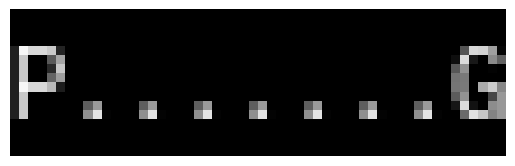

In [12]:
from srl.test import TestEnv

tester = TestEnv()
tester.play_test("MyEnv")


# 6.Q学習による学習

以下のように学習できます。

### env: MyEnv, rl: QL, max episodes: 10000, timeout:  -1.00s, max steps: -1, max train: -1
16:48:45   4.35s(  0.00s left)  44391st(10000ep) 44391tr, -1.2 0.862 0.9 re(0.879 eval), 4.4 step, 0.00s/ep, 0.000s/tr,       0 mem(45.9% PC)|epsilon 0.100|Q 8.999|td_error 0.001


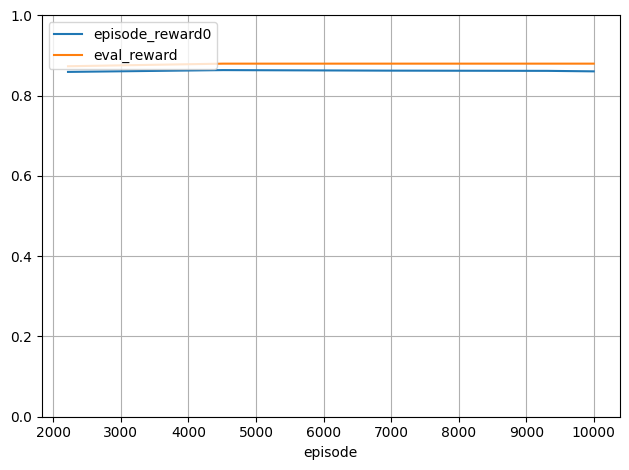

In [13]:
import srl
from srl import runner
from algorithms import ql

config = runner.Config(
    env_config=srl.EnvConfig("MyEnv"),
    rl_config=ql.Config(),  # Q学習
)

# --- train
parameter, memory, history = runner.train(config, max_episodes=10000)
history.plot(left_ymin=0, left_ymax=1)


In [14]:
rewards = runner.evaluate(config, parameter, max_episodes=100)
print("100エピソードの平均結果", np.mean(rewards))


100エピソードの平均結果 0.880000002682209


In [15]:
reward, render = runner.render(config, parameter, enable_animation=True)


### 0, action 1, rewards [0.], next 0
env   {}
work0 {'epsilon': 0}
X...P...G

 0  : 0.42669
*1  : 0.62060

### 1, action 1, rewards [-0.04], next 0 (0.0s)
env   {}
work0 {'epsilon': 0}
X....P..G

 0  : 0.51854
*1  : 0.73400

### 2, action 1, rewards [-0.04], next 0 (0.0s)
env   {}
work0 {'epsilon': 0}
X.....P.G

 0  : 0.62060
*1  : 0.86000

### 3, action 1, rewards [-0.04], next 0 (0.0s)
env   {}
work0 {'epsilon': 0}
X......PG

 0  : 0.73400
*1  : 1.00000

### 4, action 1, rewards [1.], done(env), next 0 (0.0s)
env   {}
work0 {}
X.......P



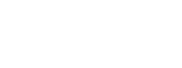

In [16]:
# render.create_anime(scale=3).save("MyEnv.gif")
render.display(scale=3)
